<a href="https://colab.research.google.com/github/reshalfahsi/web-traffic-prediction/blob/master/Web_Traffic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Web Traffic Prediction via Temporal Graph Neural Network**

## **Important Libraries**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics torch-geometric
!pip install -q --no-cache-dir torch-scatter torch-geometric-temporal

In [2]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.regression import (
    MeanAbsolutePercentageError,
    MeanAbsoluteError,
    MeanSquaredError
)

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import GConvLSTM

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import random
import math
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Dataset**

### **Train, Test, Validation Set**

In [3]:
LAG = 15
loader = WikiMathsDatasetLoader()
dataset = loader.get_dataset(lags=LAG)
print(next(iter(dataset)))
NUM_NODE = len(next(iter(dataset))['y'])
NUM_EDGE = len(next(iter(dataset))['edge_attr'])
print("Number of nodes:", NUM_NODE)
print("Number of edges:", NUM_EDGE)
# node feature is the user at time T
# x = nodes x lags or time window
# y = nodes
# edge_index = 2 x num_edge
# edge_attr = num_edge

Data(x=[1068, 15], edge_index=[2, 27079], edge_attr=[27079], y=[1068])
Number of nodes: 1068
Number of edges: 27079


In [4]:
TrainDataset, TestDataset = temporal_signal_split(dataset, train_ratio=0.9)
TrainDataset, ValDataset = temporal_signal_split(TrainDataset, train_ratio=0.9)

## **Model**

### **Utils**

In [5]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.scores = []

    def update(self, val):
        self.scores.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.scores[np.maximum(len(self.scores)-self.num, 0):]
            )
        )
        return out

### **Chebyshev Graph Convolutional Long Short Term Memory**

In [6]:
class ChebysevGConvLSTM(nn.Module):
    def __init__(self, node_features=LAG):
        super().__init__()
        self.lstm = GConvLSTM(
            in_channels=node_features,
            out_channels=32,
            K=2,
        )
        self.linear = nn.Linear(32, 1)

    def forward(
        self,
        x,
        edge_index,
        edge_weight,
    ):
        h = self.lstm(
            x,
            edge_index,
            edge_weight,
        )[0]
        h = F.relu(h)
        h = self.linear(h)
        return h

In [7]:
MODEL = ChebysevGConvLSTM
MODEL_NAME = MODEL.__name__

### **Wrapper**

In [8]:
class ModelWrapper(L.LightningModule):
    def __init__(self, arch, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.lr = lr
        self.max_epoch = max_epoch

        self.train_mape = MeanAbsolutePercentageError()
        self.train_mae = MeanAbsoluteError()
        self.train_mse = MeanSquaredError()

        self.test_mape = MeanAbsolutePercentageError()
        self.test_mae = MeanAbsoluteError()
        self.test_mse = MeanSquaredError()

        self.val_mape = MeanAbsolutePercentageError()
        self.val_mae = MeanAbsoluteError()
        self.val_mse = MeanSquaredError()

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_mape_list = []
        self.train_mae_list = []
        self.train_mse_list = []

        self.val_mape_list = []
        self.val_mae_list = []
        self.val_mse_list = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_mape_recorder = AvgMeter()
        self.train_mae_recorder = AvgMeter()
        self.train_mse_recorder = AvgMeter()

        self.val_mape_recorder = AvgMeter()
        self.val_mae_recorder = AvgMeter()
        self.val_mse_recorder = AvgMeter()

        def loss_fn(pred, target):
            return nn.MSELoss()(pred, target)

        self.loss_fn = loss_fn

        self._device = 'cpu' if not torch.cuda.is_available() else 'cuda'

    def forward(self, batch):
        return self.arch(
            batch.x,
            batch.edge_index,
            batch.edge_attr
        )

    def training_step(self, batch, batch_nb):
        y_hat = self(batch.to(self._device)).squeeze(-1)

        loss = self.loss_fn(y_hat, batch.y)

        self.train_mape.update(y_hat, batch.y)
        mape = self.train_mape.compute().data.cpu()

        self.train_mae.update(y_hat, batch.y)
        mae = self.train_mae.compute().data.cpu()

        self.train_mse.update(y_hat, batch.y)
        mse = self.train_mse.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mape", mape, prog_bar=True)
        self.log("train_mae", mae, prog_bar=True)
        self.log("train_mse", mse, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_mape_recorder.update(mape)
        self.train_mae_recorder.update(mae)
        self.train_mse_recorder.update(mse)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_mape_list.append(self.train_mape_recorder.show().data.cpu().numpy())
        self.train_mape_recorder = AvgMeter()

        self.train_mae_list.append(self.train_mae_recorder.show().data.cpu().numpy())
        self.train_mae_recorder = AvgMeter()

        self.train_mse_list.append(self.train_mse_recorder.show().data.cpu().numpy())
        self.train_mse_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        y_hat = self(batch.to(self._device)).squeeze(-1)

        loss = self.loss_fn(y_hat, batch.y)

        self.val_mape.update(y_hat, batch.y)
        mape = self.val_mape.compute().data.cpu()

        self.val_mae.update(y_hat, batch.y)
        mae = self.val_mae.compute().data.cpu()

        self.val_mse.update(y_hat, batch.y)
        mse = self.val_mse.compute().data.cpu()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mape", mape, prog_bar=True)
        self.log("val_mae", mae, prog_bar=True)
        self.log("val_mse", mse, prog_bar=True)

        self.val_loss_recorder.update(loss.data)
        self.val_mape_recorder.update(mape)
        self.val_mae_recorder.update(mae)
        self.val_mse_recorder.update(mse)

    def on_validation_epoch_end(self):
        self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
        self.val_loss_recorder = AvgMeter()

        self.val_mape_list.append(self.val_mape_recorder.show().data.cpu().numpy())
        self.val_mape_recorder = AvgMeter()

        self.val_mae_list.append(self.val_mae_recorder.show().data.cpu().numpy())
        self.val_mae_recorder = AvgMeter()

        self.val_mse_list.append(self.val_mse_recorder.show().data.cpu().numpy())
        self.val_mse_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        y_hat = self(batch.to(self._device)).squeeze(-1)

        loss = self.loss_fn(y_hat, batch.y)
        self.test_mape.update(y_hat, batch.y)
        mape = self.test_mape.compute().data.cpu()

        self.test_mae.update(y_hat, batch.y)
        mae = self.test_mae.compute().data.cpu()

        self.test_mse.update(y_hat, batch.y)
        mse = self.test_mse.compute().data.cpu()

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_mape", mape, prog_bar=True, logger=True)
        self.log("test_mae", mae, prog_bar=True, logger=True)
        self.log("test_mse", mse, prog_bar=True, logger=True)

    def eval_metric_curves(self):
        # Loss
        loss_img_file = "/content/loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # MAPE
        mape_img_file = "/content/mape_plot.png"
        plt.plot(self.train_mape_list, color="r", label="train")
        plt.plot(self.val_mape_list, color="b", label="validation")
        plt.title("MAPE Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MAPE")
        plt.legend()
        plt.grid()
        plt.savefig(mape_img_file)
        plt.clf()
        img = cv2.imread(mape_img_file)
        cv2_imshow(img)

        # MAE
        mae_img_file = "/content/mae_plot.png"
        plt.plot(self.train_mae_list, color="r", label="train")
        plt.plot(self.val_mae_list, color="b", label="validation")
        plt.title("MAE Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid()
        plt.savefig(mae_img_file)
        plt.clf()
        img = cv2.imread(mae_img_file)
        cv2_imshow(img)

        # MSE
        mse_img_file = "/content/mse_plot.png"
        plt.plot(self.train_mse_list, color="r", label="train")
        plt.plot(self.val_mse_list, color="b", label="validation")
        plt.title("MSE Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.legend()
        plt.grid()
        plt.savefig(mse_img_file)
        plt.clf()
        img = cv2.imread(mse_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return TrainDataset

    def val_dataloader(self):
        return ValDataset

    def test_dataloader(self):
        return TestDataset

    def configure_optimizers(self):
        step_factor = math.sqrt(self.max_epoch)
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=1e-4,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * idx / step_factor)
                    for idx in range(int(step_factor) - 1)
                ],
                gamma=1 / step_factor,
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

## **Training**

In [ ]:
MAX_EPOCH = 100
LR = 1e-2
CHECKPOINT_DIR = os.getcwd()
SEED = int(np.random.randint(2147483647))

print(f"Random seed: {SEED}")

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs/lightning_logs/

In [11]:
seed_everything(SEED, workers=True)

model = MODEL()
model = ModelWrapper(model, LR, MAX_EPOCH)

tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_mae',
    dirpath=CHECKPOINT_DIR,
    filename=f"{MODEL_NAME}_best",
    mode='min',
)
early_stopping = EarlyStopping(
    monitor="val_mae",
    min_delta=0.00,
    patience=7,
    verbose=False,
    mode="min",
)

trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(model)

INFO: Global seed set to 1280659242
INFO:lightning.fabric.utilities.seed:Global seed set to 1280659242
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                        | Params
-----------------------------------------------------------
0 | arch       | ChebysevGConvLSTM           | 12.5 K
1 | train_mape | MeanAbsolutePercentageError | 0     
2 | train_mae  | MeanAbsoluteError   

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


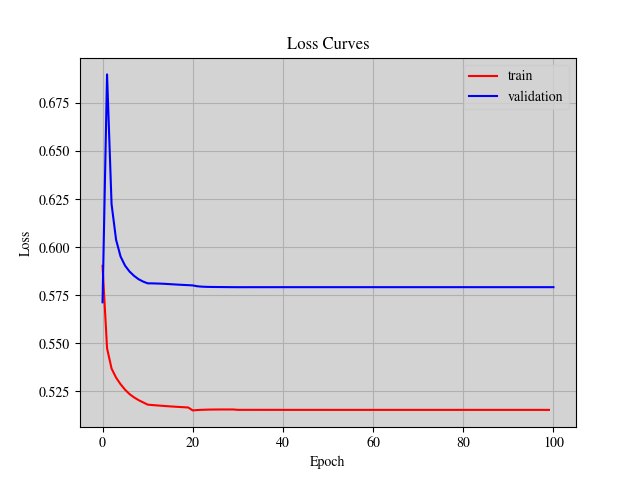

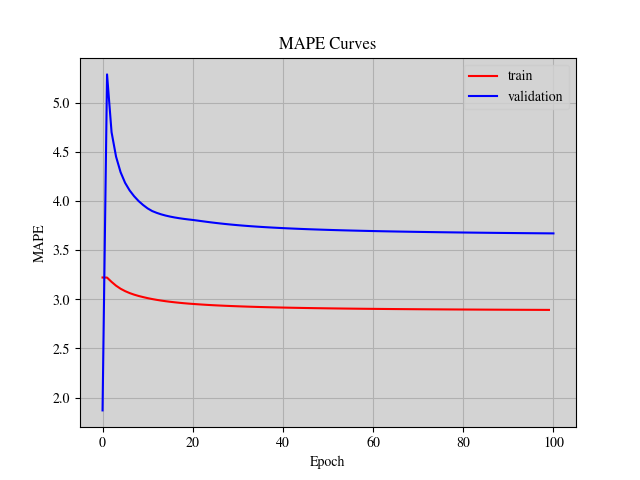

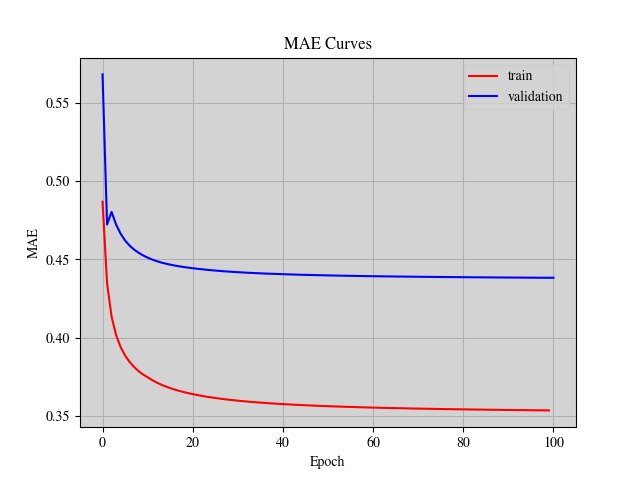

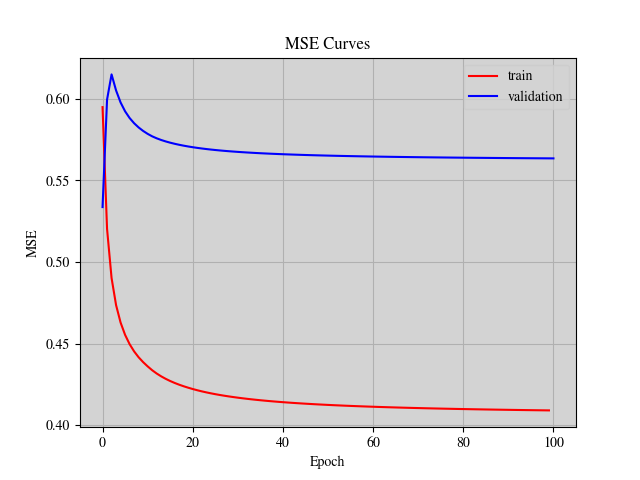

<Figure size 640x480 with 0 Axes>

In [12]:
trainer.strategy._lightning_module.eval_metric_curves()

## **Testing**

In [13]:
trainer.test(ckpt_path='best')

INFO: Restoring states from the checkpoint path at /content/ChebysevGConvLSTM_best-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ChebysevGConvLSTM_best-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ChebysevGConvLSTM_best-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/ChebysevGConvLSTM_best-v1.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.45152631402015686    │
│         test_mae          │    0.43804219365119934    │
│         test_mape         │     4.110334873199463     │
│         test_mse          │    0.5185727477073669     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.45152631402015686,
  'test_mape': 4.110334873199463,
  'test_mae': 0.43804219365119934,
  'test_mse': 0.5185727477073669}]

In [14]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)

## **Inference**

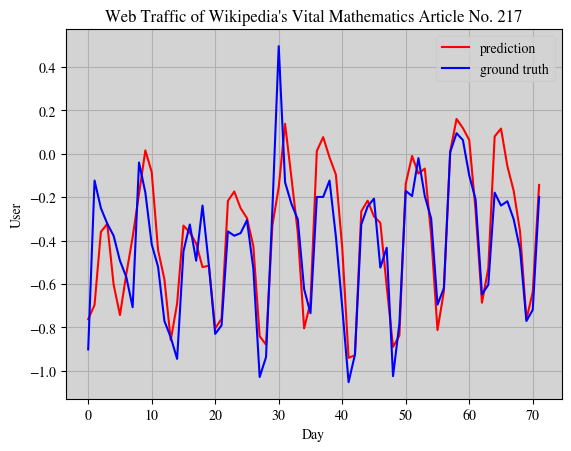

In [17]:
device = "cpu" if not torch.cuda.is_available() else "cuda"

model = ModelWrapper.load_from_checkpoint(
    checkpoint_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"),
    map_location=device,
    arch=MODEL(),
    lr=LR,
    max_epoch=MAX_EPOCH,
)

prediction = list()
ground_truth = list()

page_index = random.randint(0, NUM_NODE - 1)

for index in range(len(TestDataset.targets)):
    __data__ = TestDataset[index]
    prediction.append(
        model(__data__.to(device)).squeeze(-1)[page_index].detach().cpu().numpy()
    )
    ground_truth.append(__data__.y[page_index].detach().cpu().numpy())

plt.clf()
plt.plot(prediction, color="r", label="prediction")
plt.plot(ground_truth, color="b", label="ground truth")
plt.title(f"Web Traffic of Wikipedia's Vital Mathematics Article No. {page_index}")
plt.xlabel(f"Day")
plt.ylabel("User")
plt.legend()
plt.grid()
plt.show()